<a href="https://colab.research.google.com/github/vibhuverma17/XGB_DEEP_DIVE/blob/main/Research_3_Credit_Card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost pandas scikit-learn
!pip install kaggle
# !kaggle competitions download -c allstate-claims-severity
!mkdir Data

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
warnings.filterwarnings("ignore")

mkdir: cannot create directory ‘Data’: File exists


In [ ]:
# Load the data
# test = pd.read_csv('/content/Data/test.csv')
train = pd.read_csv('/content/Data/creditcard.csv')

# Display the first few rows of the training data
print("Training Data:")
# print(train.head())

print(train.shape)

train.drop(columns=['Time'],axis=1)
# test.drop(columns=['id'],axis=1)

# Split the data into features (X) and target (y
X = train.drop(columns=['Time','Class'])
y = train['Class']

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# Convert categorical features to category dtype
for feature in categorical_features:
    X[feature] = X[feature].astype('category')
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

Training Data:
(284807, 31)


### LEARNING RATE

In [ ]:
# Define the range of learning rates to test
learning_rate_start = 0.01
learning_rate_end = 1
num_learning_rates = 100  # Number of learning rates to generate
learning_rates = np.linspace(learning_rate_start, learning_rate_end, num_learning_rates)

# Prepare DataFrames to store gain data and performance metrics
all_gain_data = pd.DataFrame()
all_metrics_data = pd.DataFrame()

# Assuming X_train, y_train, X_test, and y_test are already defined

# Loop over each learning rate
for lr in learning_rates:
    # Define hyperparameters for the model
    hyperparameters = {
        'booster': 'gbtree',
        'learning_rate': lr,
        'max_depth': 6,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 1,
        'colsample_bytree': 1,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'scale_pos_weight': 1,
        'objective': 'binary:logistic',
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 1,
        'early_stopping_rounds': None,
        'seed': 42,
        'eval_metric': 'logloss'
    }

    # Train the model
    model = xgb.XGBClassifier(**hyperparameters,n_estimators=100)
    model.fit(X_train, y_train)

    # Extract the Booster and calculate gain using get_score()
    booster = model.get_booster()
    tree_df = booster.trees_to_dataframe()

    # Convert gain_dict to DataFrame
    tree_df = tree_df[['Tree'	,'Node',	'Feature',	'Split',	'Yes',	'No',	'Missing',	'Gain','Cover']]

    tree_df['is_root_split'] = tree_df['Node'] == 0

    # Check if the 'Default' column exists
    if 'Default' in tree_df.columns:
        # Extract relevant columns, including default values and hyperparameters
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'Default', 'is_root_split']]
    else:
        # If 'Default' does not exist, exclude it
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'is_root_split']]

    # Add learning rate and hyperparameters for traceability
    gain_data['Hyperparameters'] = str(hyperparameters)

    # Concatenate gain_data for this learning rate to the overall gain DataFrame
    all_gain_data = pd.concat([all_gain_data, gain_data], ignore_index=True)

    # Make predictions on training and test sets
    y_pred_train = model.predict_proba(X_train)[:, 1]
    y_pred_test = model.predict_proba(X_test)[:, 1]

    # Convert predictions to binary labels (0 or 1)
    y_pred_train_binary = (y_pred_train > 0.5).astype(int)
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)

    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_pred_train_binary)
    train_precision = precision_score(y_train, y_pred_train_binary)
    train_recall = recall_score(y_train, y_pred_train_binary)
    train_f1 = f1_score(y_train, y_pred_train_binary)
    train_auc = roc_auc_score(y_train, y_pred_train)

    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_pred_test_binary)
    test_precision = precision_score(y_test, y_pred_test_binary)
    test_recall = recall_score(y_test, y_pred_test_binary)
    test_f1 = f1_score(y_test, y_pred_test_binary)
    test_auc = roc_auc_score(y_test, y_pred_test_binary)

    # Store all metrics in a DataFrame for this iteration
    metrics_data = pd.DataFrame({
        'Learning_Rate': [lr],
        'Train_Accuracy': [train_accuracy],
        'Train_Precision': [train_precision],
        'Train_Recall': [train_recall],
        'Train_F1': [train_f1],
        'Train_AUC': [train_auc],
        'Test_Accuracy': [test_accuracy],
        'Test_Precision': [test_precision],
        'Test_Recall': [test_recall],
        'Test_F1': [test_f1],
        'Test_AUC': [test_auc],
        'Hyperparameters': [str(hyperparameters)]
    })

    # Concatenate metrics data to the overall DataFrame
    all_metrics_data = pd.concat([all_metrics_data, metrics_data], ignore_index=True)


In [ ]:
# Display the first few rows of the metrics DataFrame
print("\nMetrics Data for different learning rates:")
all_metrics_data.head()


Metrics Data for different learning rates:


,Learning_Rate,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Train_AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC,Hyperparameters
0,0.01,0.999539,0.976898,0.751269,0.849354,0.922223,0.999421,0.957746,0.693878,0.804734,0.846912,"{'booster': 'gbtree', 'learning_rate': 0.01, '..."
1,0.02,0.999662,0.973134,0.827411,0.894376,0.973640,0.999544,0.961538,0.765306,0.852273,0.882627,"{'booster': 'gbtree', 'learning_rate': 0.02, '..."
2,0.03,0.999710,0.988095,0.842640,0.909589,0.974871,0.999526,0.949367,0.765306,0.847458,0.882618,"{'booster': 'gbtree', 'learning_rate': 0.03, '..."
3,0.04,0.999737,0.991176,0.855330,0.918256,0.987391,0.999561,0.939759,0.795918,0.861878,0.897915,"{'booster': 'gbtree', 'learning_rate': 0.04, '..."
4,0.05,0.999767,0.997085,0.868020,0.928087,0.995749,0.999526,0.917647,0.795918,0.852459,0.897898,"{'booster': 'gbtree', 'learning_rate': 0.05, '..."


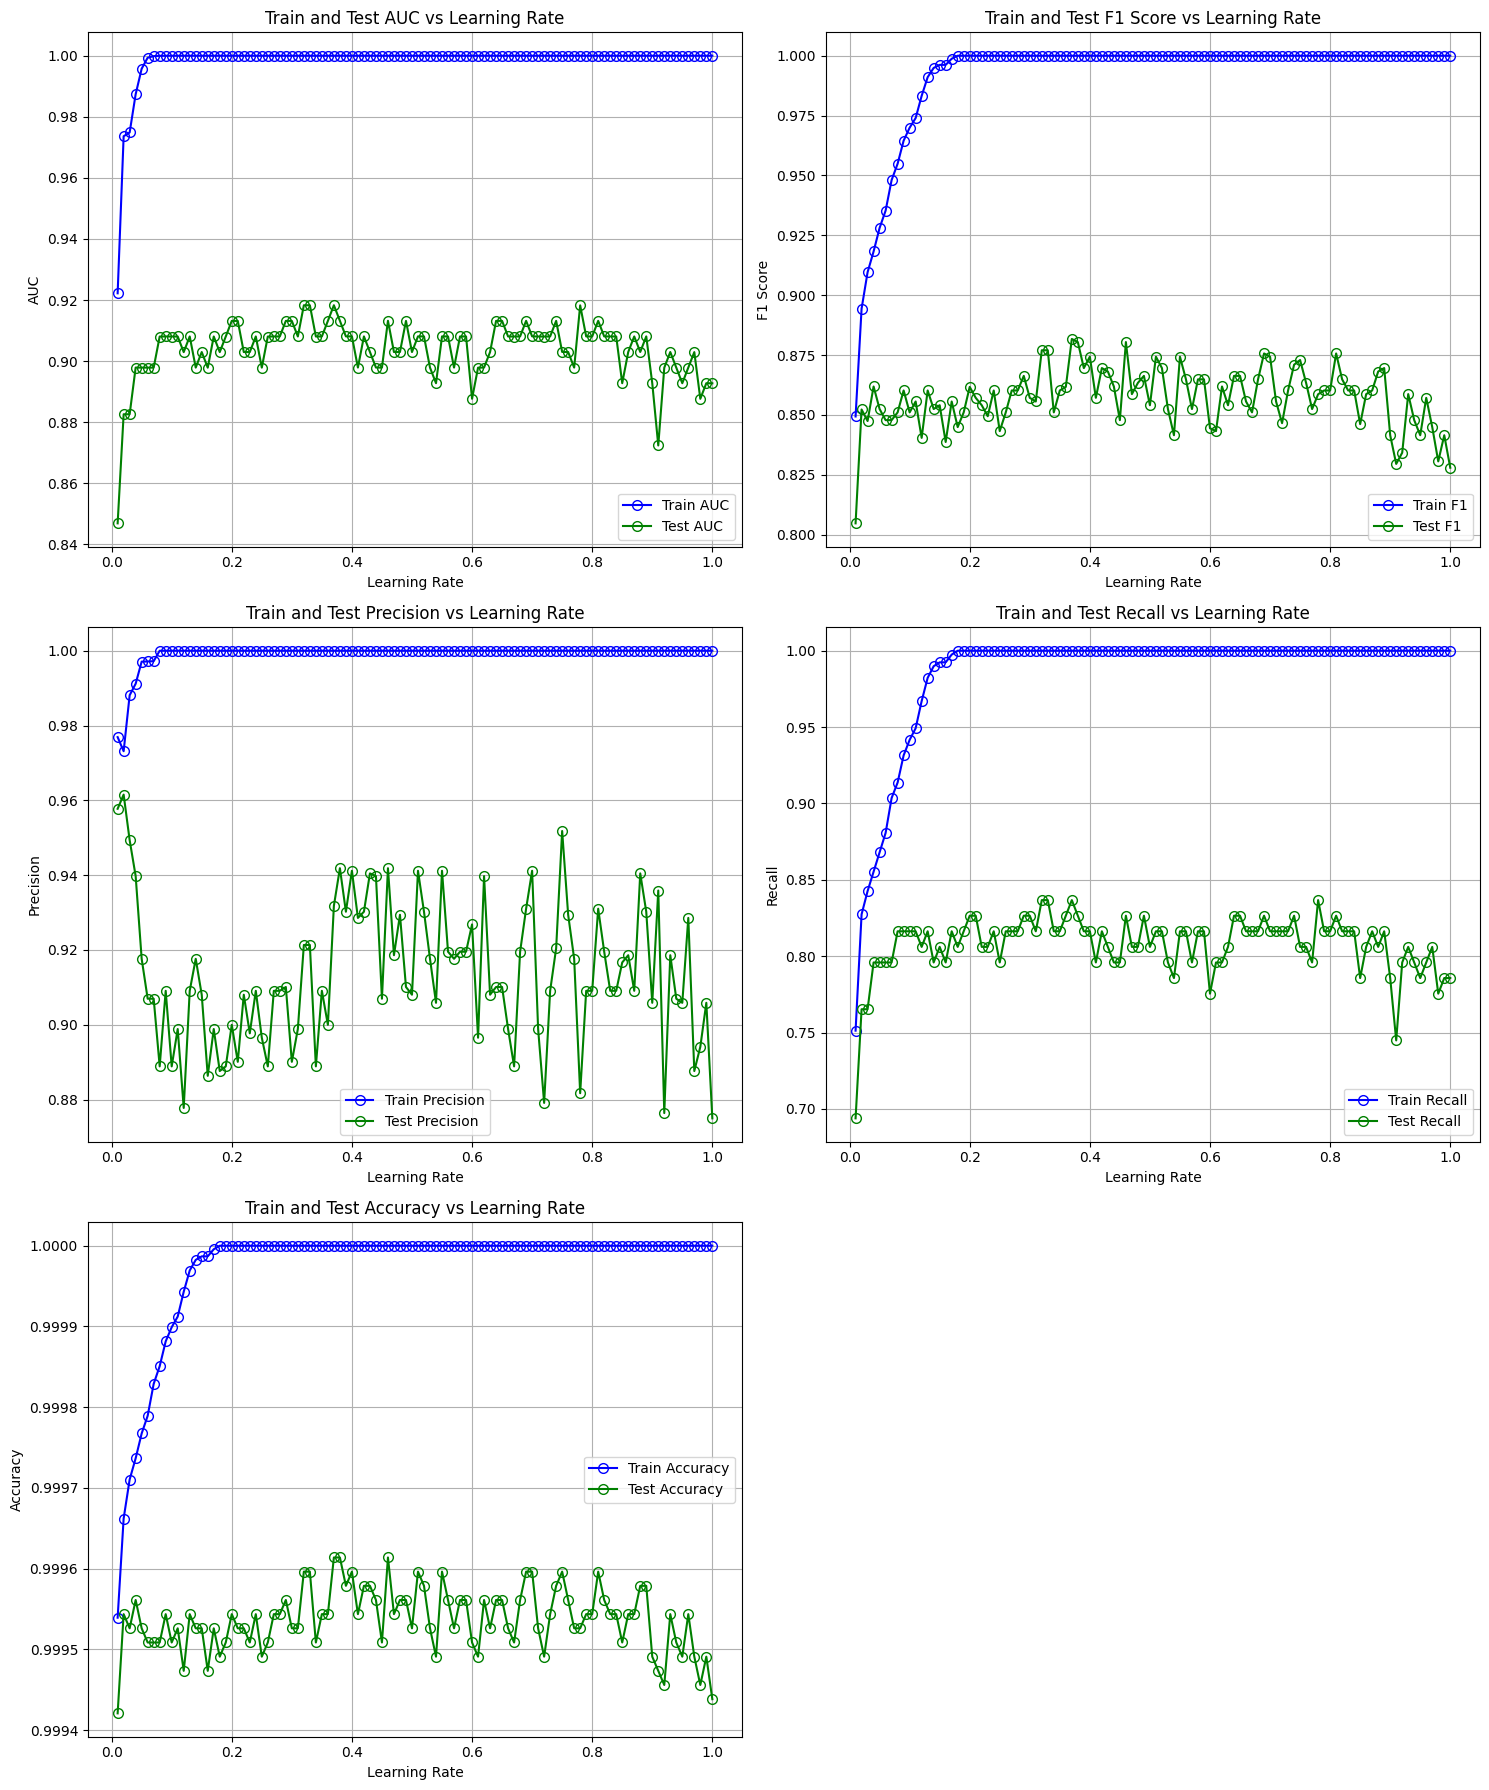

In [ ]:
# Create the subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Define colors and marker size
train_color = 'blue'
test_color = 'green'
marker_size = 7  # Adjust this value for finer dots

# Plot 1: Train and Test AUC vs Learning Rate
axes[0, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_AUC'], label='Train AUC',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_AUC'], label='Test AUC',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('AUC')
axes[0, 0].set_title('Train and Test AUC vs Learning Rate')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Train and Test F1 vs Learning Rate
axes[0, 1].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_F1'], label='Train F1',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 1].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_F1'], label='Test F1',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Train and Test F1 Score vs Learning Rate')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Train and Test Precision vs Learning Rate
axes[1, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_Precision'], label='Train Precision',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_Precision'], label='Test Precision',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Train and Test Precision vs Learning Rate')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Train and Test Recall vs Learning Rate
axes[1, 1].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_Recall'], label='Train Recall',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 1].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_Recall'], label='Test Recall',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Train and Test Recall vs Learning Rate')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Plot 5: Train and Test Accuracy vs Learning Rate
axes[2, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Train_Accuracy'], label='Train Accuracy',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[2, 0].plot(all_metrics_data['Learning_Rate'], all_metrics_data['Test_Accuracy'], label='Test Accuracy',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[2, 0].set_xlabel('Learning Rate')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].set_title('Train and Test Accuracy vs Learning Rate')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Remove the empty subplot
axes[2, 1].remove()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Print best learning rates for each metric
metrics = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
for metric in metrics:
    best_lr_idx = all_metrics_data[f'Test_{metric}'].idxmax()
    best_lr = all_metrics_data.loc[best_lr_idx, 'Learning_Rate']
    best_score = all_metrics_data.loc[best_lr_idx, f'Test_{metric}']
    print(f"\nBest Learning Rate for {metric}: {best_lr:.4f}")
    print(f"Best Test {metric}: {best_score:.4f}")

In [ ]:
# Convert the 'Hyperparameters' column from string to dictionary
all_gain_data['Hyperparameters_Dict'] = all_gain_data['Hyperparameters'].apply(ast.literal_eval)
all_gain_data['Learning_Rate_Value'] = all_gain_data['Hyperparameters_Dict'].apply(lambda x: x['learning_rate'])

all_gain_data


Best Learning Rate for AUC: 0.3700
Best Test AUC: 0.9183

Best Learning Rate for F1: 0.3700
Best Test F1: 0.8817

Best Learning Rate for Precision: 0.0200
Best Test Precision: 0.9615

Best Learning Rate for Recall: 0.3200
Best Test Recall: 0.8367

Best Learning Rate for Accuracy: 0.3700
Best Test Accuracy: 0.9996


,Tree,Node,Feature,Gain,is_root_split,Hyperparameters,Hyperparameters_Dict,Learning_Rate_Value
0,0,0,V14,1024.191410,True,"{'booster': 'gbtree', 'learning_rate': 0.01, '...","{'booster': 'gbtree', 'learning_rate': 0.01, '...",0.01
1,0,1,V10,1289.008180,False,"{'booster': 'gbtree', 'learning_rate': 0.01, '...","{'booster': 'gbtree', 'learning_rate': 0.01, '...",0.01
2,0,2,V17,7.876953,False,"{'booster': 'gbtree', 'learning_rate': 0.01, '...","{'booster': 'gbtree', 'learning_rate': 0.01, '...",0.01
3,0,3,V7,59.456421,False,"{'booster': 'gbtree', 'learning_rate': 0.01, '...","{'booster': 'gbtree', 'learning_rate': 0.01, '...",0.01
4,0,4,V7,37.375092,False,"{'booster': 'gbtree', 'learning_rate': 0.01, '...","{'booster': 'gbtree', 'learning_rate': 0.01, '...",0.01
...,...,...,...,...,...,...,...,...
309249,99,0,V6,0.017552,True,"{'booster': 'gbtree', 'learning_rate': 1.0, 'm...","{'booster': 'gbtree', 'learning_rate': 1.0, 'm...",1.00
309250,99,1,V15,0.018263,False,"{'booster': 'gbtree', 'learning_rate': 1.0, 'm...","{'booster': 'gbtree', 'learning_rate': 1.0, 'm...",1.00
309251,99,2,Leaf,-0.070547,False,"{'booster': 'gbtree', 'learning_rate': 1.0, 'm...","{'booster': 'gbtree', 'learning_rate': 1.0, 'm...",1.00
309252,99,3,Leaf,0.084030,False,"{'booster': 'gbtree', 'learning_rate': 1.0, 'm...","{'booster': 'gbtree', 'learning_rate': 1.0, 'm...",1.00


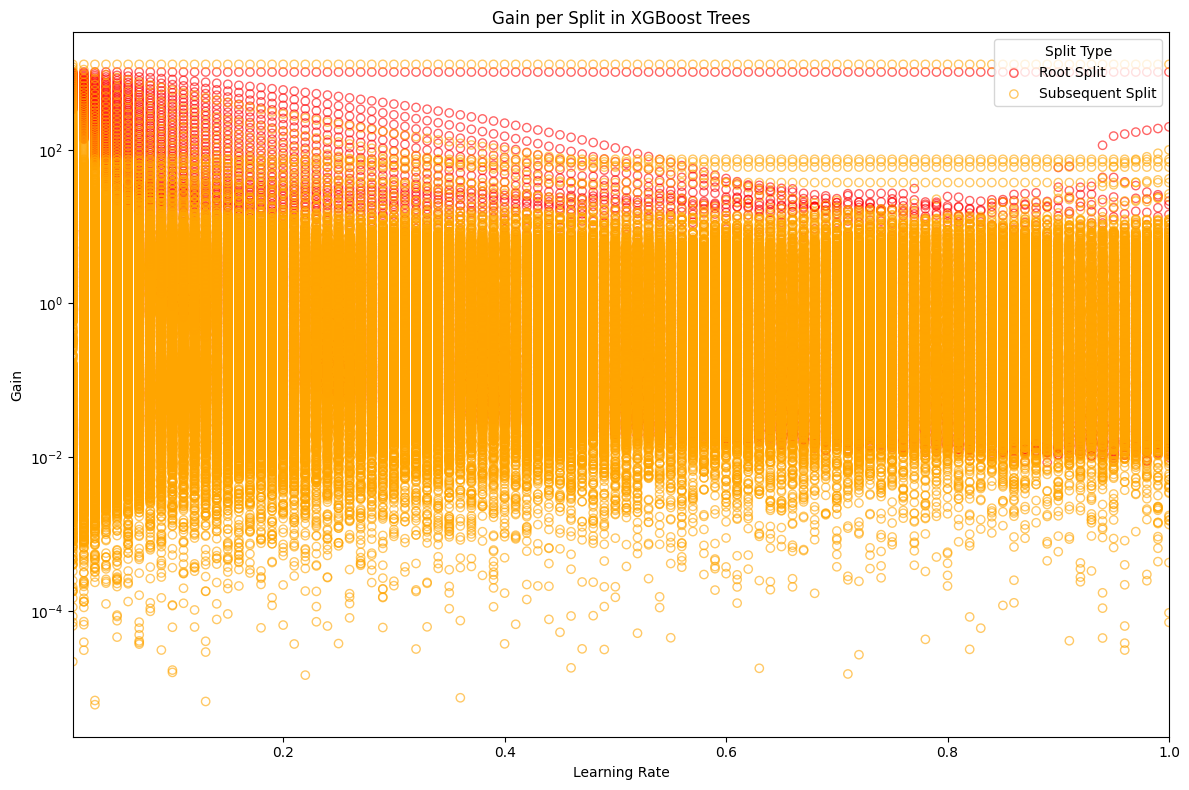

In [ ]:
# Define the feature for the X-axis
feature = 'Learning_Rate_Value'

# Create the plot
plt.figure(figsize=(12, 8))

# Plotting for root splits (is_root_split=True)
sns.scatterplot(
    data=all_gain_data[all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='red',                   # Red edge color for root splits
    sizes=(20, 500),
    edgecolor='red',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Plotting for non-root splits (is_root_split=False)
sns.scatterplot(
    data=all_gain_data[~all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='orange',                # Orange edge color for subsequent splits
    sizes=(20, 500),
    edgecolor='orange',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Set plot labels and title
plt.xlim(all_gain_data[feature].min(), all_gain_data[feature].max())
plt.title('Gain per Split in XGBoost Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Gain')

# Adjust the legend title and labels manually
plt.legend(['Root Split', 'Subsequent Split'], title='Split Type', loc='upper right')

# Set the Y-axis to a logarithmic scale
plt.yscale('log')

# Remove the grid lines
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()


### MAX DEPTH

In [ ]:
# Define range for max_depth
max_depth_start = 1
max_depth_end = 50  # High end for the maximum depth range
max_depth_gap = 5   # Increase in steps of 5 for higher values
max_depth_list = list(range(max_depth_start, max_depth_end + 1, max_depth_gap)) + [None]  # None for unrestricted depth

# Prepare DataFrames to store gain data and performance metrics
all_gain_data = pd.DataFrame()
all_metrics_data = pd.DataFrame()

# Assuming X_train, y_train, X_test, and y_test are already defined

# Loop over each max_depth
for max_depth in max_depth_list:
    # Define hyperparameters for the model
    hyperparameters = {
        'booster': 'gbtree',
        'learning_rate': 0.3,
        'max_depth': max_depth,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 1,
        'colsample_bytree': 1,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'scale_pos_weight': 1,
        'objective': 'binary:logistic',
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 1,
        'early_stopping_rounds': None,
        'seed': 42,
        'eval_metric': 'logloss'
    }

    # Train the model
    model = xgb.XGBClassifier(**hyperparameters, n_estimators=100)
    model.fit(X_train, y_train)

    # Extract the Booster and calculate gain using get_score()
    booster = model.get_booster()
    tree_df = booster.trees_to_dataframe()

    # Convert gain_dict to DataFrame
    tree_df = tree_df[['Tree', 'Node', 'Feature', 'Split', 'Yes', 'No', 'Missing', 'Gain', 'Cover']]

    tree_df['is_root_split'] = tree_df['Node'] == 0

    # Check if the 'Default' column exists
    if 'Default' in tree_df.columns:
        # Extract relevant columns, including default values and hyperparameters
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'Default', 'is_root_split']]
    else:
        # If 'Default' does not exist, exclude it
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'is_root_split']]

    # Add max depth and hyperparameters for traceability
    gain_data['Hyperparameters'] = str(hyperparameters)

    # Concatenate gain_data for this max depth to the overall gain DataFrame
    all_gain_data = pd.concat([all_gain_data, gain_data], ignore_index=True)

    # Make predictions on training and test sets
    y_pred_train = model.predict_proba(X_train)[:, 1]
    y_pred_test = model.predict_proba(X_test)[:, 1]

    # Convert predictions to binary labels (0 or 1)
    y_pred_train_binary = (y_pred_train > 0.5).astype(int)
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)

    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_pred_train_binary)
    train_precision = precision_score(y_train, y_pred_train_binary)
    train_recall = recall_score(y_train, y_pred_train_binary)
    train_f1 = f1_score(y_train, y_pred_train_binary)
    train_auc = roc_auc_score(y_train, y_pred_train)

    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_pred_test_binary)
    test_precision = precision_score(y_test, y_pred_test_binary)
    test_recall = recall_score(y_test, y_pred_test_binary)
    test_f1 = f1_score(y_test, y_pred_test_binary)
    test_auc = roc_auc_score(y_test, y_pred_test_binary)

    # Store all metrics in a DataFrame for this iteration
    metrics_data = pd.DataFrame({
        'Max_Depth': [max_depth],
        'Train_Accuracy': [train_accuracy],
        'Train_Precision': [train_precision],
        'Train_Recall': [train_recall],
        'Train_F1': [train_f1],
        'Train_AUC': [train_auc],
        'Test_Accuracy': [test_accuracy],
        'Test_Precision': [test_precision],
        'Test_Recall': [test_recall],
        'Test_F1': [test_f1],
        'Test_AUC': [test_auc],
        'Hyperparameters': [str(hyperparameters)]
    })

    # Concatenate metrics data to the overall DataFrame
    all_metrics_data = pd.concat([all_metrics_data, metrics_data], ignore_index=True)

In [ ]:
# Display the first few rows of the metrics DataFrame
print("\nMetrics Data for different learning rates:")
all_metrics_data.head()


Metrics Data for different learning rates:


,Max_Depth,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Train_AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC,Hyperparameters
0,1,0.999465,0.895349,0.781726,0.834688,0.992438,0.999386,0.831579,0.806122,0.818653,0.902921,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
1,6,1.000000,1.000000,1.000000,1.000000,1.000000,0.999526,0.890110,0.826531,0.857143,0.913177,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
2,11,1.000000,1.000000,1.000000,1.000000,1.000000,0.999579,0.920455,0.826531,0.870968,0.913204,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
3,16,1.000000,1.000000,1.000000,1.000000,1.000000,0.999561,0.910112,0.826531,0.866310,0.913195,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
4,21,1.000000,1.000000,1.000000,1.000000,1.000000,0.999561,0.910112,0.826531,0.866310,0.913195,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."


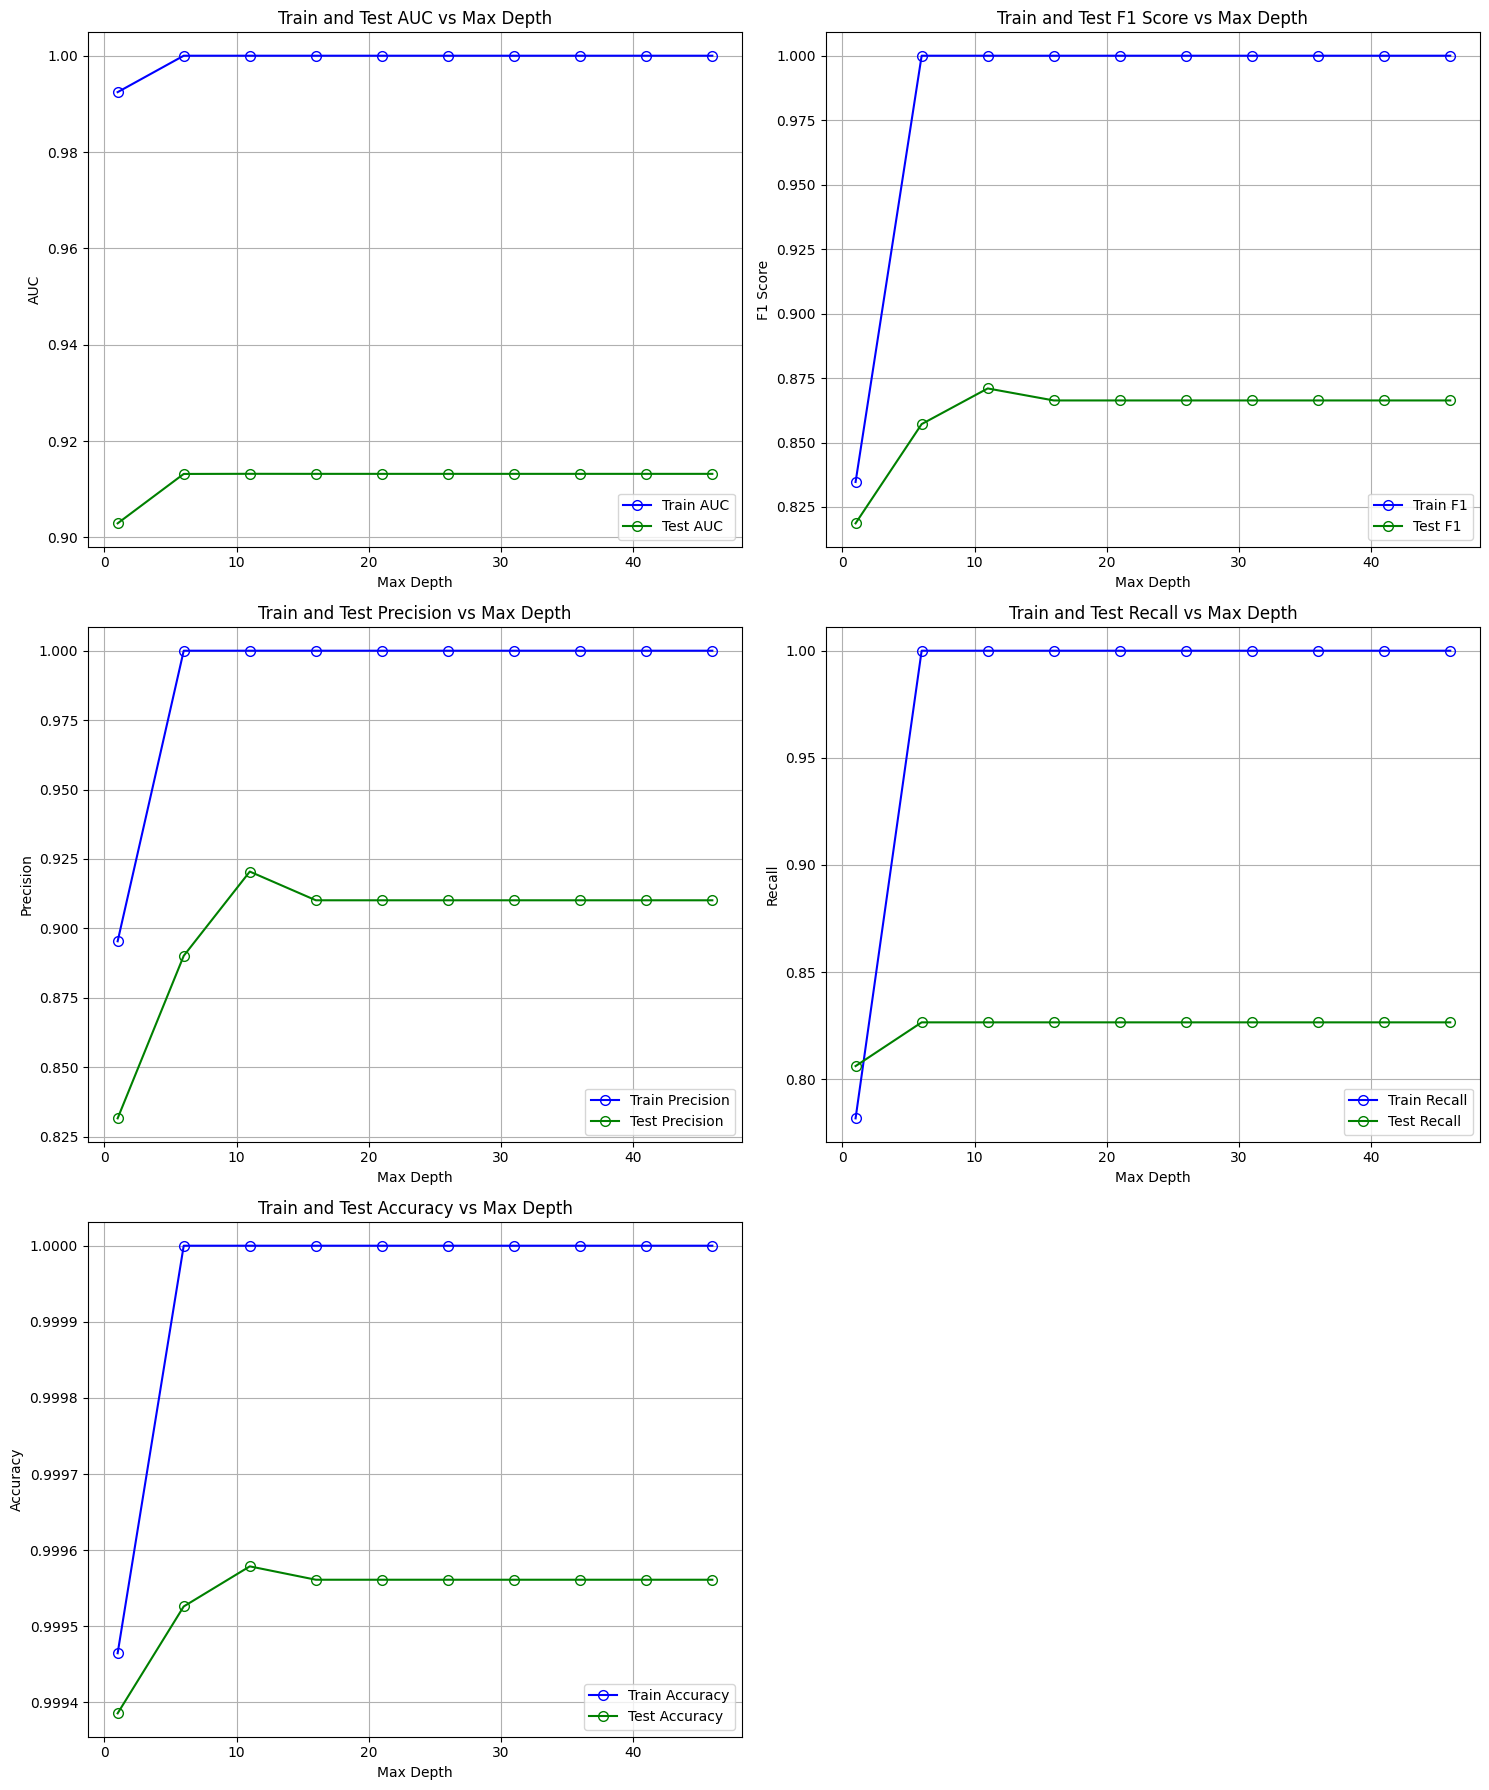

In [ ]:
# Create the subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Define colors and marker size
train_color = 'blue'
test_color = 'green'
marker_size = 7  # Adjust this value for finer dots

# Plot 1: Train and Test AUC vs Max Depth
axes[0, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_AUC'], label='Train AUC',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_AUC'], label='Test AUC',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 0].set_xlabel('Max Depth')
axes[0, 0].set_ylabel('AUC')
axes[0, 0].set_title('Train and Test AUC vs Max Depth')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Train and Test F1 vs Max Depth
axes[0, 1].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_F1'], label='Train F1',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 1].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_F1'], label='Test F1',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 1].set_xlabel('Max Depth')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Train and Test F1 Score vs Max Depth')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Train and Test Precision vs Max Depth
axes[1, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_Precision'], label='Train Precision',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_Precision'], label='Test Precision',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 0].set_xlabel('Max Depth')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Train and Test Precision vs Max Depth')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Train and Test Recall vs Max Depth
axes[1, 1].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_Recall'], label='Train Recall',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 1].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_Recall'], label='Test Recall',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 1].set_xlabel('Max Depth')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Train and Test Recall vs Max Depth')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Plot 5: Train and Test Accuracy vs Max Depth
axes[2, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Train_Accuracy'], label='Train Accuracy',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[2, 0].plot(all_metrics_data['Max_Depth'], all_metrics_data['Test_Accuracy'], label='Test Accuracy',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[2, 0].set_xlabel('Max Depth')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].set_title('Train and Test Accuracy vs Max Depth')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Remove the empty subplot
axes[2, 1].remove()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# Print best learning rates for each metric
metrics = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
for metric in metrics:
    best_lr_idx = all_metrics_data[f'Test_{metric}'].idxmax()
    best_lr = all_metrics_data.loc[best_lr_idx, 'Max_Depth']
    best_score = all_metrics_data.loc[best_lr_idx, f'Test_{metric}']
    print(f"\nBest Max_Depth for {metric}: {best_lr:.4f}")
    print(f"Best Test {metric}: {best_score:.4f}")

In [ ]:
# Convert the 'Hyperparameters' column from string to dictionary
all_gain_data['Hyperparameters_Dict'] = all_gain_data['Hyperparameters'].apply(ast.literal_eval)
all_gain_data['max_depth_Value'] = all_gain_data['Hyperparameters_Dict'].apply(lambda x: x['max_depth'])

all_gain_data.head()

,Tree,Node,Feature,Gain,is_root_split,Hyperparameters,Hyperparameters_Dict,max_depth_Value
0,0,0,V14,1024.191410,True,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...","{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
1,0,1,Leaf,0.647522,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...","{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
2,0,2,Leaf,-0.339841,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...","{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
3,1,0,V10,799.447266,True,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...","{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
4,1,1,Leaf,0.527887,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...","{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0


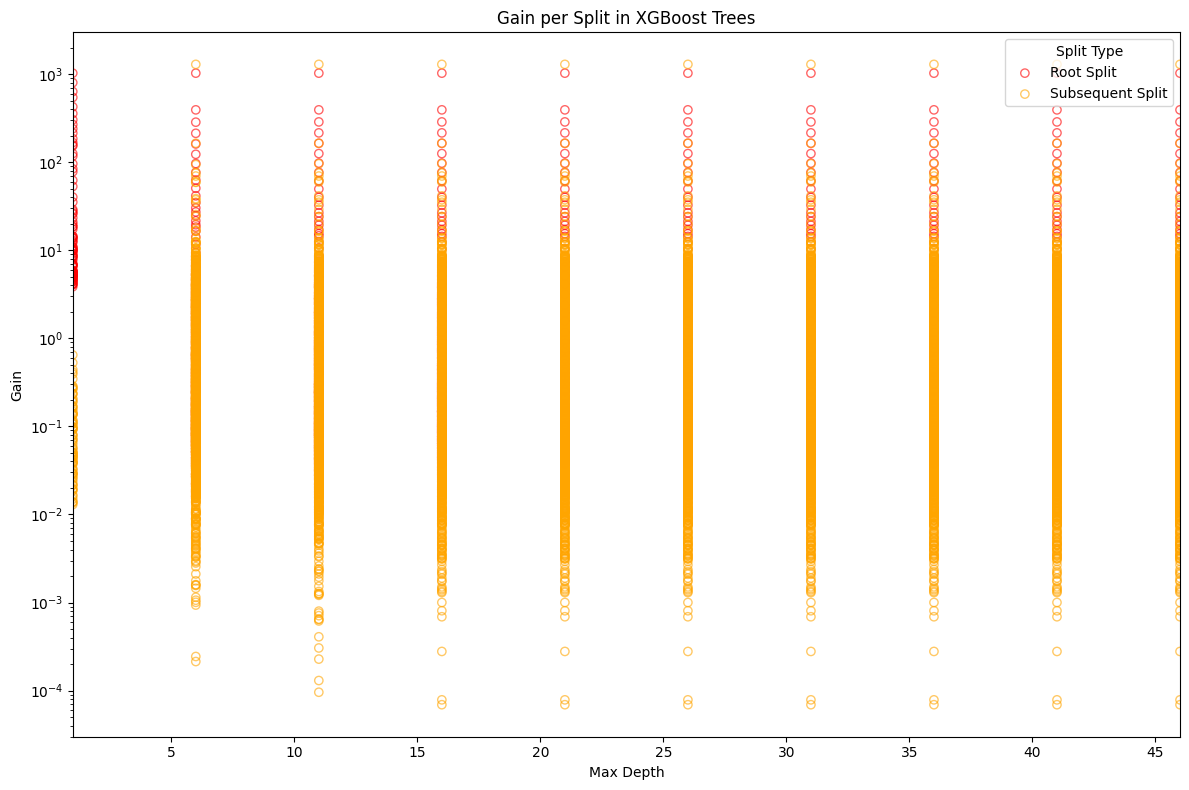

In [ ]:
# Define the feature for the X-axis
feature = 'max_depth_Value'

# Create the plot
plt.figure(figsize=(12, 8))

# Plotting for root splits (is_root_split=True)
sns.scatterplot(
    data=all_gain_data[all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='red',                   # Red edge color for root splits
    sizes=(20, 500),
    edgecolor='red',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Plotting for non-root splits (is_root_split=False)
sns.scatterplot(
    data=all_gain_data[~all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    # size='Gain',
    color='orange',                # Orange edge color for subsequent splits
    sizes=(20, 500),
    edgecolor='orange',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Set plot labels and title
plt.xlim(all_gain_data[feature].min(), all_gain_data[feature].max())
plt.title('Gain per Split in XGBoost Trees')
plt.xlabel('Max Depth')
plt.ylabel('Gain')

# Adjust the legend title and labels manually
plt.legend(['Root Split', 'Subsequent Split'], title='Split Type', loc='upper right')

# Set the Y-axis to a logarithmic scale
plt.yscale('log')

# Remove the grid lines
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()


### N_ESTIMATORS

In [ ]:
# Define range for num_boost_round (number of boosting rounds or trees)
num_boost_round_list = [1, 5, 10,20,30,40] + list(range(50, 550, 50))   # Adjust range and step as needed

# Initialize DataFrames to store results
all_gain_data = pd.DataFrame()
all_metrics_data = pd.DataFrame()

# Loop over each num_boost_round value
for num_boost in num_boost_round_list:
    # Define hyperparameters for the model
    hyperparameters = {
        'booster': 'gbtree',
        'learning_rate': 0.3,
        'max_depth': 6,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 1,
        'colsample_bytree': 1,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'scale_pos_weight': 1,
        'objective': 'binary:logistic',
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 1,
        'early_stopping_rounds': None,
        'seed': 42,
        'eval_metric': 'logloss'
    }

    # Train the model
    model = xgb.XGBClassifier(**hyperparameters, n_estimators=num_boost)

    model.fit(X_train, y_train)

    # Extract the Booster and calculate gain using get_score()
    booster = model.get_booster()
    tree_df = booster.trees_to_dataframe()

    # Convert gain_dict to DataFrame
    tree_df = tree_df[['Tree', 'Node', 'Feature', 'Split', 'Yes', 'No', 'Missing', 'Gain', 'Cover']]

    tree_df['is_root_split'] = tree_df['Node'] == 0

    # Check if the 'Default' column exists
    if 'Default' in tree_df.columns:
        # Extract relevant columns, including default values and hyperparameters
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'Default', 'is_root_split']]
    else:
        # If 'Default' does not exist, exclude it
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'is_root_split']]

    # Add n_estimators and hyperparameters for traceability
    gain_data['Hyperparameters'] = str(hyperparameters)
    gain_data['num_boost_round'] = num_boost

    # Concatenate gain_data for this n_estimator to the overall gain DataFrame
    all_gain_data = pd.concat([all_gain_data, gain_data], ignore_index=True)

    # Make predictions on training and test sets
    y_pred_train = model.predict_proba(X_train)[:, 1]
    y_pred_test = model.predict_proba(X_test)[:, 1]

    # Convert predictions to binary labels (0 or 1)
    y_pred_train_binary = (y_pred_train > 0.5).astype(int)
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)

    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_pred_train_binary)
    train_precision = precision_score(y_train, y_pred_train_binary)
    train_recall = recall_score(y_train, y_pred_train_binary)
    train_f1 = f1_score(y_train, y_pred_train_binary)
    train_auc = roc_auc_score(y_train, y_pred_train)

    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_pred_test_binary)
    test_precision = precision_score(y_test, y_pred_test_binary)
    test_recall = recall_score(y_test, y_pred_test_binary)
    test_f1 = f1_score(y_test, y_pred_test_binary)
    test_auc = roc_auc_score(y_test, y_pred_test_binary)

    # Store all metrics in a DataFrame for this iteration
    metrics_data = pd.DataFrame({
        'num_boost_round': [num_boost],
        'Train_Accuracy': [train_accuracy],
        'Train_Precision': [train_precision],
        'Train_Recall': [train_recall],
        'Train_F1': [train_f1],
        'Train_AUC': [train_auc],
        'Test_Accuracy': [test_accuracy],
        'Test_Precision': [test_precision],
        'Test_Recall': [test_recall],
        'Test_F1': [test_f1],
        'Test_AUC': [test_auc],
        'Hyperparameters': [str(hyperparameters)]
    })

    # Concatenate metrics data to the overall DataFrame
    all_metrics_data = pd.concat([all_metrics_data, metrics_data], ignore_index=True)

In [ ]:
# Display the first few rows of the metrics DataFrame
print("\nMetrics Data for different learning rates:")
all_metrics_data.head()


Metrics Data for different learning rates:


,num_boost_round,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Train_AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC,Hyperparameters
0,1,0.999254,0.948000,0.601523,0.736025,0.922184,0.999210,0.934426,0.581633,0.716981,0.790781,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
1,5,0.999631,0.964072,0.817259,0.884615,0.948769,0.999473,0.935897,0.744898,0.829545,0.872405,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
2,10,0.999693,0.979290,0.840102,0.904372,0.974334,0.999544,0.928571,0.795918,0.857143,0.897906,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
3,20,0.999789,0.997126,0.880711,0.935310,0.999115,0.999508,0.888889,0.816327,0.851064,0.908075,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
4,30,0.999881,1.000000,0.931472,0.964520,0.999989,0.999491,0.887640,0.806122,0.844920,0.902973,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."


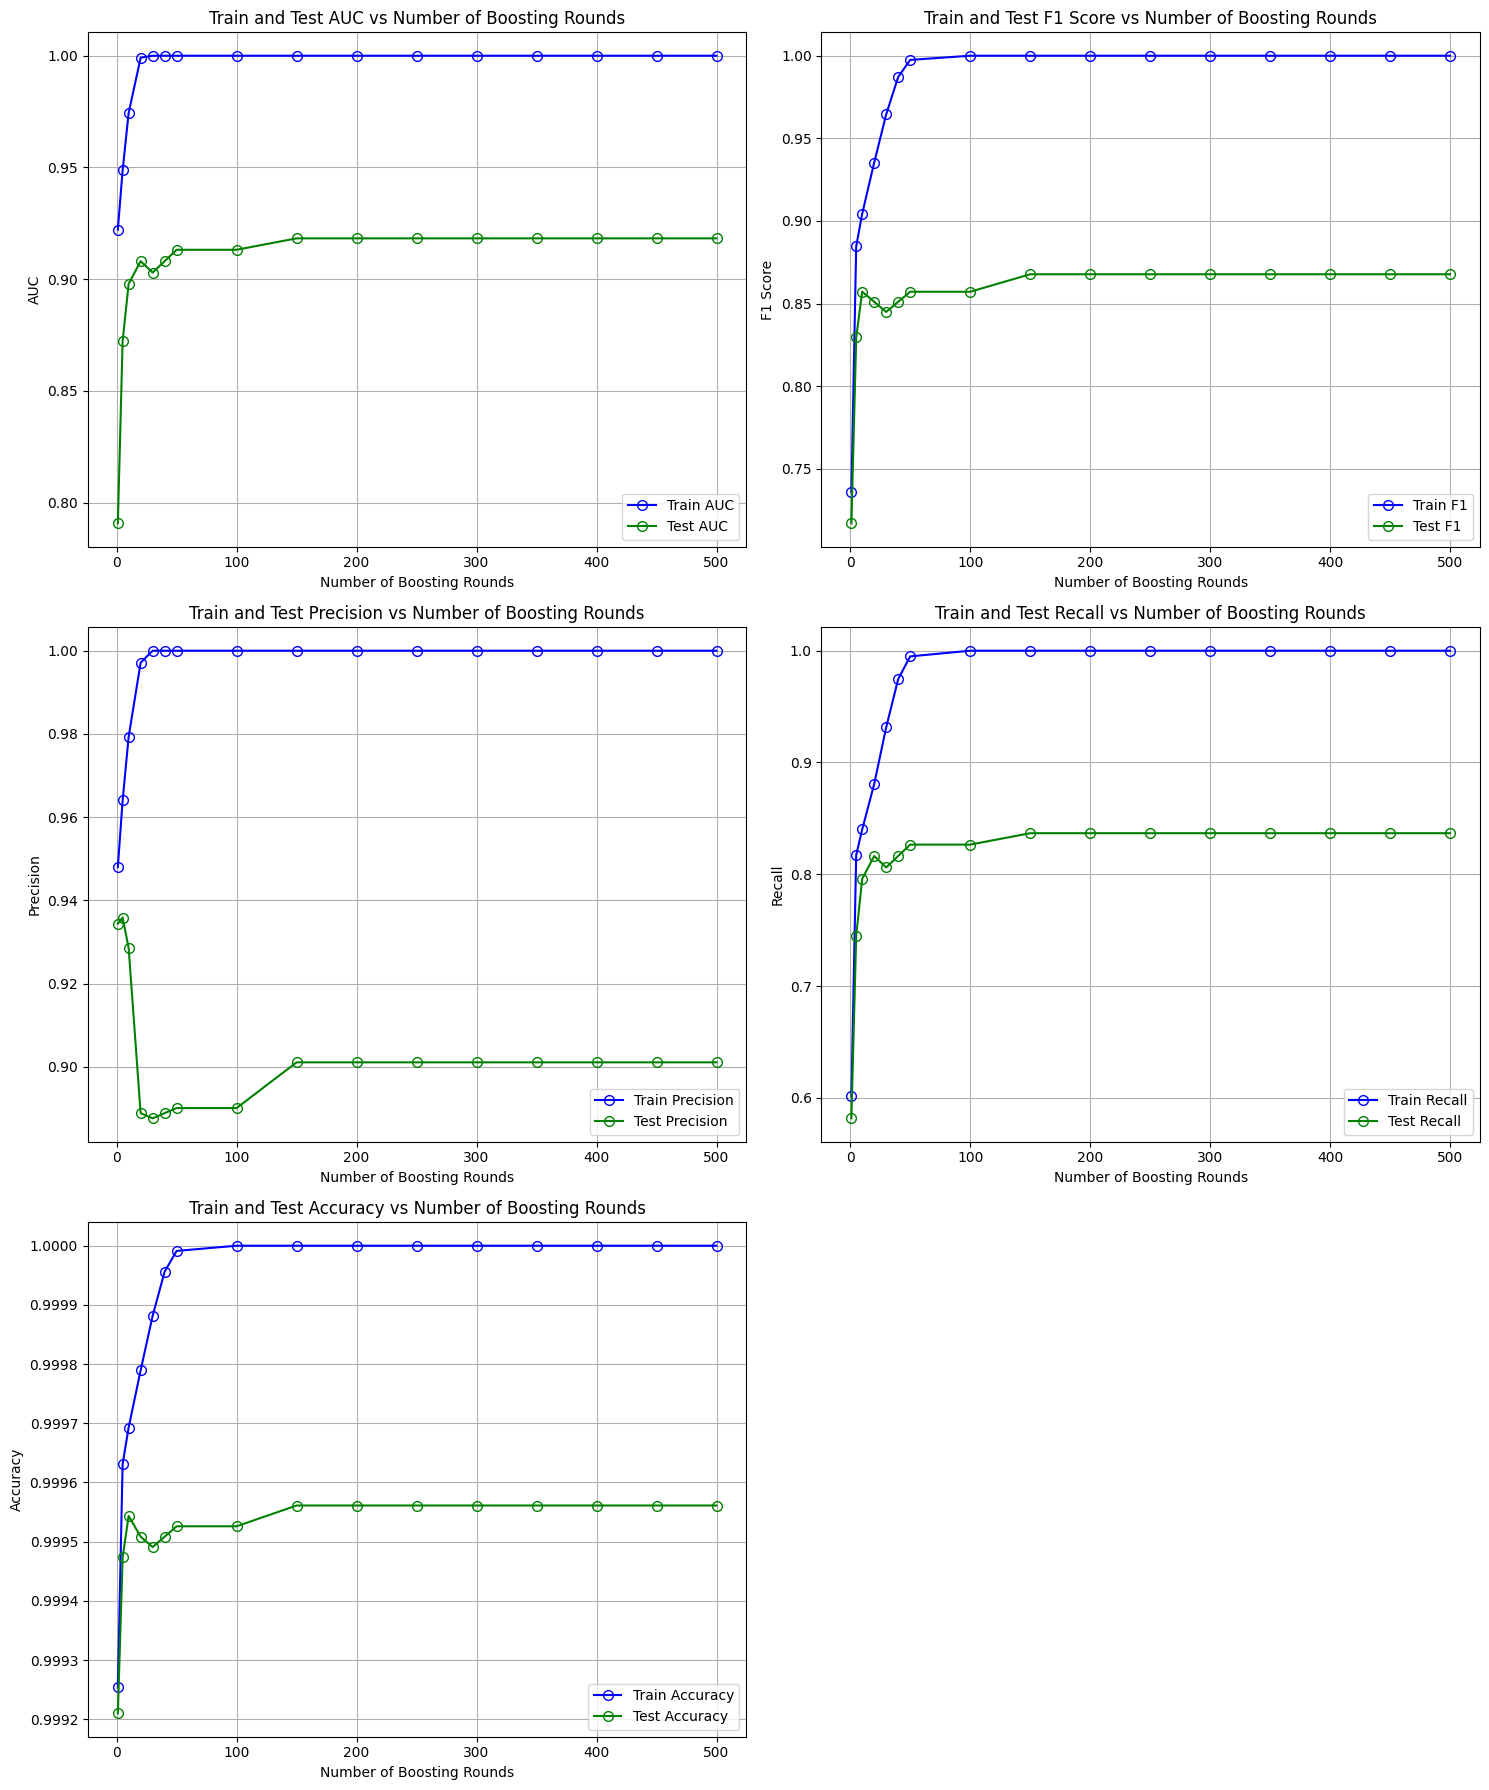


Best Number of Boosting Rounds for AUC: 150
Best Test AUC: 0.9183

Best Number of Boosting Rounds for F1: 150
Best Test F1: 0.8677

Best Number of Boosting Rounds for Precision: 5
Best Test Precision: 0.9359

Best Number of Boosting Rounds for Recall: 150
Best Test Recall: 0.8367

Best Number of Boosting Rounds for Accuracy: 150
Best Test Accuracy: 0.9996


In [ ]:
# Create the subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Define colors and marker size
train_color = 'blue'
test_color = 'green'
marker_size = 7  # Adjust this value for finer dots

# Plot 1: Train and Test AUC vs num_boost_round
axes[0, 0].plot(all_metrics_data['num_boost_round'], all_metrics_data['Train_AUC'], label='Train AUC',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 0].plot(all_metrics_data['num_boost_round'], all_metrics_data['Test_AUC'], label='Test AUC',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 0].set_xlabel('Number of Boosting Rounds')
axes[0, 0].set_ylabel('AUC')
axes[0, 0].set_title('Train and Test AUC vs Number of Boosting Rounds')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Train and Test F1 vs num_boost_round
axes[0, 1].plot(all_metrics_data['num_boost_round'], all_metrics_data['Train_F1'], label='Train F1',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 1].plot(all_metrics_data['num_boost_round'], all_metrics_data['Test_F1'], label='Test F1',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 1].set_xlabel('Number of Boosting Rounds')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Train and Test F1 Score vs Number of Boosting Rounds')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Train and Test Precision vs num_boost_round
axes[1, 0].plot(all_metrics_data['num_boost_round'], all_metrics_data['Train_Precision'], label='Train Precision',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 0].plot(all_metrics_data['num_boost_round'], all_metrics_data['Test_Precision'], label='Test Precision',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 0].set_xlabel('Number of Boosting Rounds')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Train and Test Precision vs Number of Boosting Rounds')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Train and Test Recall vs num_boost_round
axes[1, 1].plot(all_metrics_data['num_boost_round'], all_metrics_data['Train_Recall'], label='Train Recall',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 1].plot(all_metrics_data['num_boost_round'], all_metrics_data['Test_Recall'], label='Test Recall',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 1].set_xlabel('Number of Boosting Rounds')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Train and Test Recall vs Number of Boosting Rounds')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Plot 5: Train and Test Accuracy vs num_boost_round
axes[2, 0].plot(all_metrics_data['num_boost_round'], all_metrics_data['Train_Accuracy'], label='Train Accuracy',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[2, 0].plot(all_metrics_data['num_boost_round'], all_metrics_data['Test_Accuracy'], label='Test Accuracy',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[2, 0].set_xlabel('Number of Boosting Rounds')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].set_title('Train and Test Accuracy vs Number of Boosting Rounds')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Remove the empty subplot
axes[2, 1].remove()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Print best num_boost_round values for each metric
metrics = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
for metric in metrics:
    best_round_idx = all_metrics_data[f'Test_{metric}'].idxmax()
    best_round = all_metrics_data.loc[best_round_idx, 'num_boost_round']
    best_score = all_metrics_data.loc[best_round_idx, f'Test_{metric}']
    print(f"\nBest Number of Boosting Rounds for {metric}: {best_round}")
    print(f"Best Test {metric}: {best_score:.4f}")


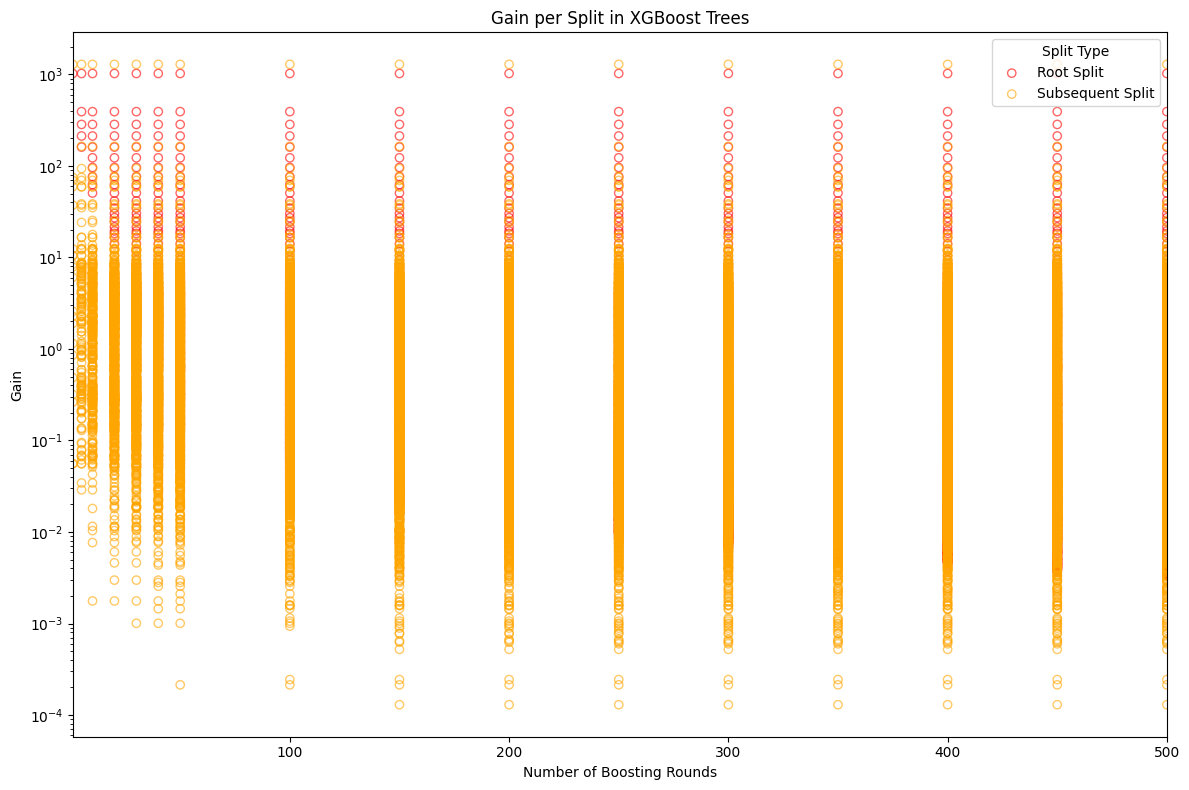

In [ ]:
# Define the feature for the X-axis
feature = 'num_boost_round'

# Create the plot
plt.figure(figsize=(12, 8))

# Plotting for root splits (is_root_split=True)
sns.scatterplot(
    data=all_gain_data[all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    color='red',                   # Red edge color for root splits
    sizes=(20, 500),
    edgecolor='red',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Plotting for non-root splits (is_root_split=False)
sns.scatterplot(
    data=all_gain_data[~all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    color='orange',                # Orange edge color for subsequent splits
    sizes=(20, 500),
    edgecolor='orange',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Set plot labels and title
plt.xlim(all_gain_data[feature].min(), all_gain_data[feature].max())
plt.title('Gain per Split in XGBoost Trees')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Gain')

# Adjust the legend title and labels manually
plt.legend(['Root Split', 'Subsequent Split'], title='Split Type', loc='upper right')

# Set the Y-axis to a logarithmic scale
plt.yscale('log')

# Remove the grid lines
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

### MIN CHILD WEIGHT

In [ ]:
# Define the range of min_child_weight values with a step of 0.5
min_child_weight_start = 1
min_child_weight_end = 20
min_child_weight_step = 0.5
min_child_weight_values = np.arange(min_child_weight_start, min_child_weight_end + min_child_weight_step, min_child_weight_step)


# Initialize DataFrames to store results
all_gain_data = pd.DataFrame()
all_metrics_data = pd.DataFrame()

# Loop over each min_child_weight value
for min_child_weight in min_child_weight_values:
    # Define hyperparameters for the model
    hyperparameters = {
        'booster': 'gbtree',
        'learning_rate': 0.3,
        'max_depth': 6,
        'min_child_weight': min_child_weight,  # Update min_child_weight here
        'gamma': 0,
        'subsample': 1,
        'colsample_bytree': 1,
        'colsample_bylevel': 1,
        'colsample_bynode': 1,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'scale_pos_weight': 1,
        'objective': 'binary:logistic',
        'tree_method': 'auto',
        'n_jobs': -1,
        'verbosity': 1,
        'early_stopping_rounds': None,
        'seed': 42,
        'eval_metric': 'logloss'
    }

    # Train the model
    model = xgb.XGBClassifier(**hyperparameters, n_estimators=100)
    model.fit(X_train, y_train)

    # Extract the Booster and calculate gain using get_score()
    booster = model.get_booster()
    tree_df = booster.trees_to_dataframe()

    # Convert gain_dict to DataFrame
    tree_df = tree_df[['Tree', 'Node', 'Feature', 'Split', 'Yes', 'No', 'Missing', 'Gain', 'Cover']]

    tree_df['is_root_split'] = tree_df['Node'] == 0

    # Check if the 'Default' column exists
    if 'Default' in tree_df.columns:
        # Extract relevant columns, including default values and hyperparameters
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'Default', 'is_root_split']]
    else:
        # If 'Default' does not exist, exclude it
        gain_data = tree_df[['Tree', 'Node', 'Feature', 'Gain', 'is_root_split']]

    # Add min_child_weight and hyperparameters for traceability
    gain_data['Hyperparameters'] = str(hyperparameters)
    gain_data['min_child_weight'] = min_child_weight

    # Concatenate gain_data for this min_child_weight to the overall gain DataFrame
    all_gain_data = pd.concat([all_gain_data, gain_data], ignore_index=True)

    # Make predictions on training and test sets
    y_pred_train = model.predict_proba(X_train)[:, 1]
    y_pred_test = model.predict_proba(X_test)[:, 1]

    # Convert predictions to binary labels (0 or 1)
    y_pred_train_binary = (y_pred_train > 0.5).astype(int)
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)

    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_pred_train_binary)
    train_precision = precision_score(y_train, y_pred_train_binary)
    train_recall = recall_score(y_train, y_pred_train_binary)
    train_f1 = f1_score(y_train, y_pred_train_binary)
    train_auc = roc_auc_score(y_train, y_pred_train)

    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_pred_test_binary)
    test_precision = precision_score(y_test, y_pred_test_binary)
    test_recall = recall_score(y_test, y_pred_test_binary)
    test_f1 = f1_score(y_test, y_pred_test_binary)
    test_auc = roc_auc_score(y_test, y_pred_test_binary)

    # Store all metrics in a DataFrame for this iteration
    metrics_data = pd.DataFrame({
        'min_child_weight': [min_child_weight],
        'Train_Accuracy': [train_accuracy],
        'Train_Precision': [train_precision],
        'Train_Recall': [train_recall],
        'Train_F1': [train_f1],
        'Train_AUC': [train_auc],
        'Test_Accuracy': [test_accuracy],
        'Test_Precision': [test_precision],
        'Test_Recall': [test_recall],
        'Test_F1': [test_f1],
        'Test_AUC': [test_auc],
        'Hyperparameters': [str(hyperparameters)]
    })

    # Concatenate metrics data to the overall DataFrame
    all_metrics_data = pd.concat([all_metrics_data, metrics_data], ignore_index=True)

In [ ]:
# Display the first few rows of the metrics DataFrame
print("\nMetrics Data for different learning rates:")
all_metrics_data.head()


Metrics Data for different learning rates:


,min_child_weight,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Train_AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_AUC,Hyperparameters
0,1.0,1.000000,1.0,1.000000,1.000000,1.0,0.999526,0.890110,0.826531,0.857143,0.913177,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
1,1.5,1.000000,1.0,1.000000,1.000000,1.0,0.999579,0.920455,0.826531,0.870968,0.913204,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
2,2.0,1.000000,1.0,1.000000,1.000000,1.0,0.999579,0.920455,0.826531,0.870968,0.913204,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
3,2.5,0.999996,1.0,0.997462,0.998729,1.0,0.999579,0.951220,0.795918,0.866667,0.897924,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."
4,3.0,0.999996,1.0,0.997462,0.998729,1.0,0.999561,0.919540,0.816327,0.864865,0.908102,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm..."


In [ ]:
all_gain_data[all_gain_data['min_child_weight']==1]

,Tree,Node,Feature,Gain,is_root_split,Hyperparameters,min_child_weight
0,0,0,V14,1024.191410,True,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
1,0,1,V10,1289.008180,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
2,0,2,V17,7.876953,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
3,0,3,V7,59.456421,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
4,0,4,V7,37.375092,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
...,...,...,...,...,...,...,...
3617,99,12,V19,0.118305,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
3618,99,13,Leaf,-0.108512,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
3619,99,14,Leaf,-0.016122,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0
3620,99,15,Leaf,0.054895,False,"{'booster': 'gbtree', 'learning_rate': 0.3, 'm...",1.0


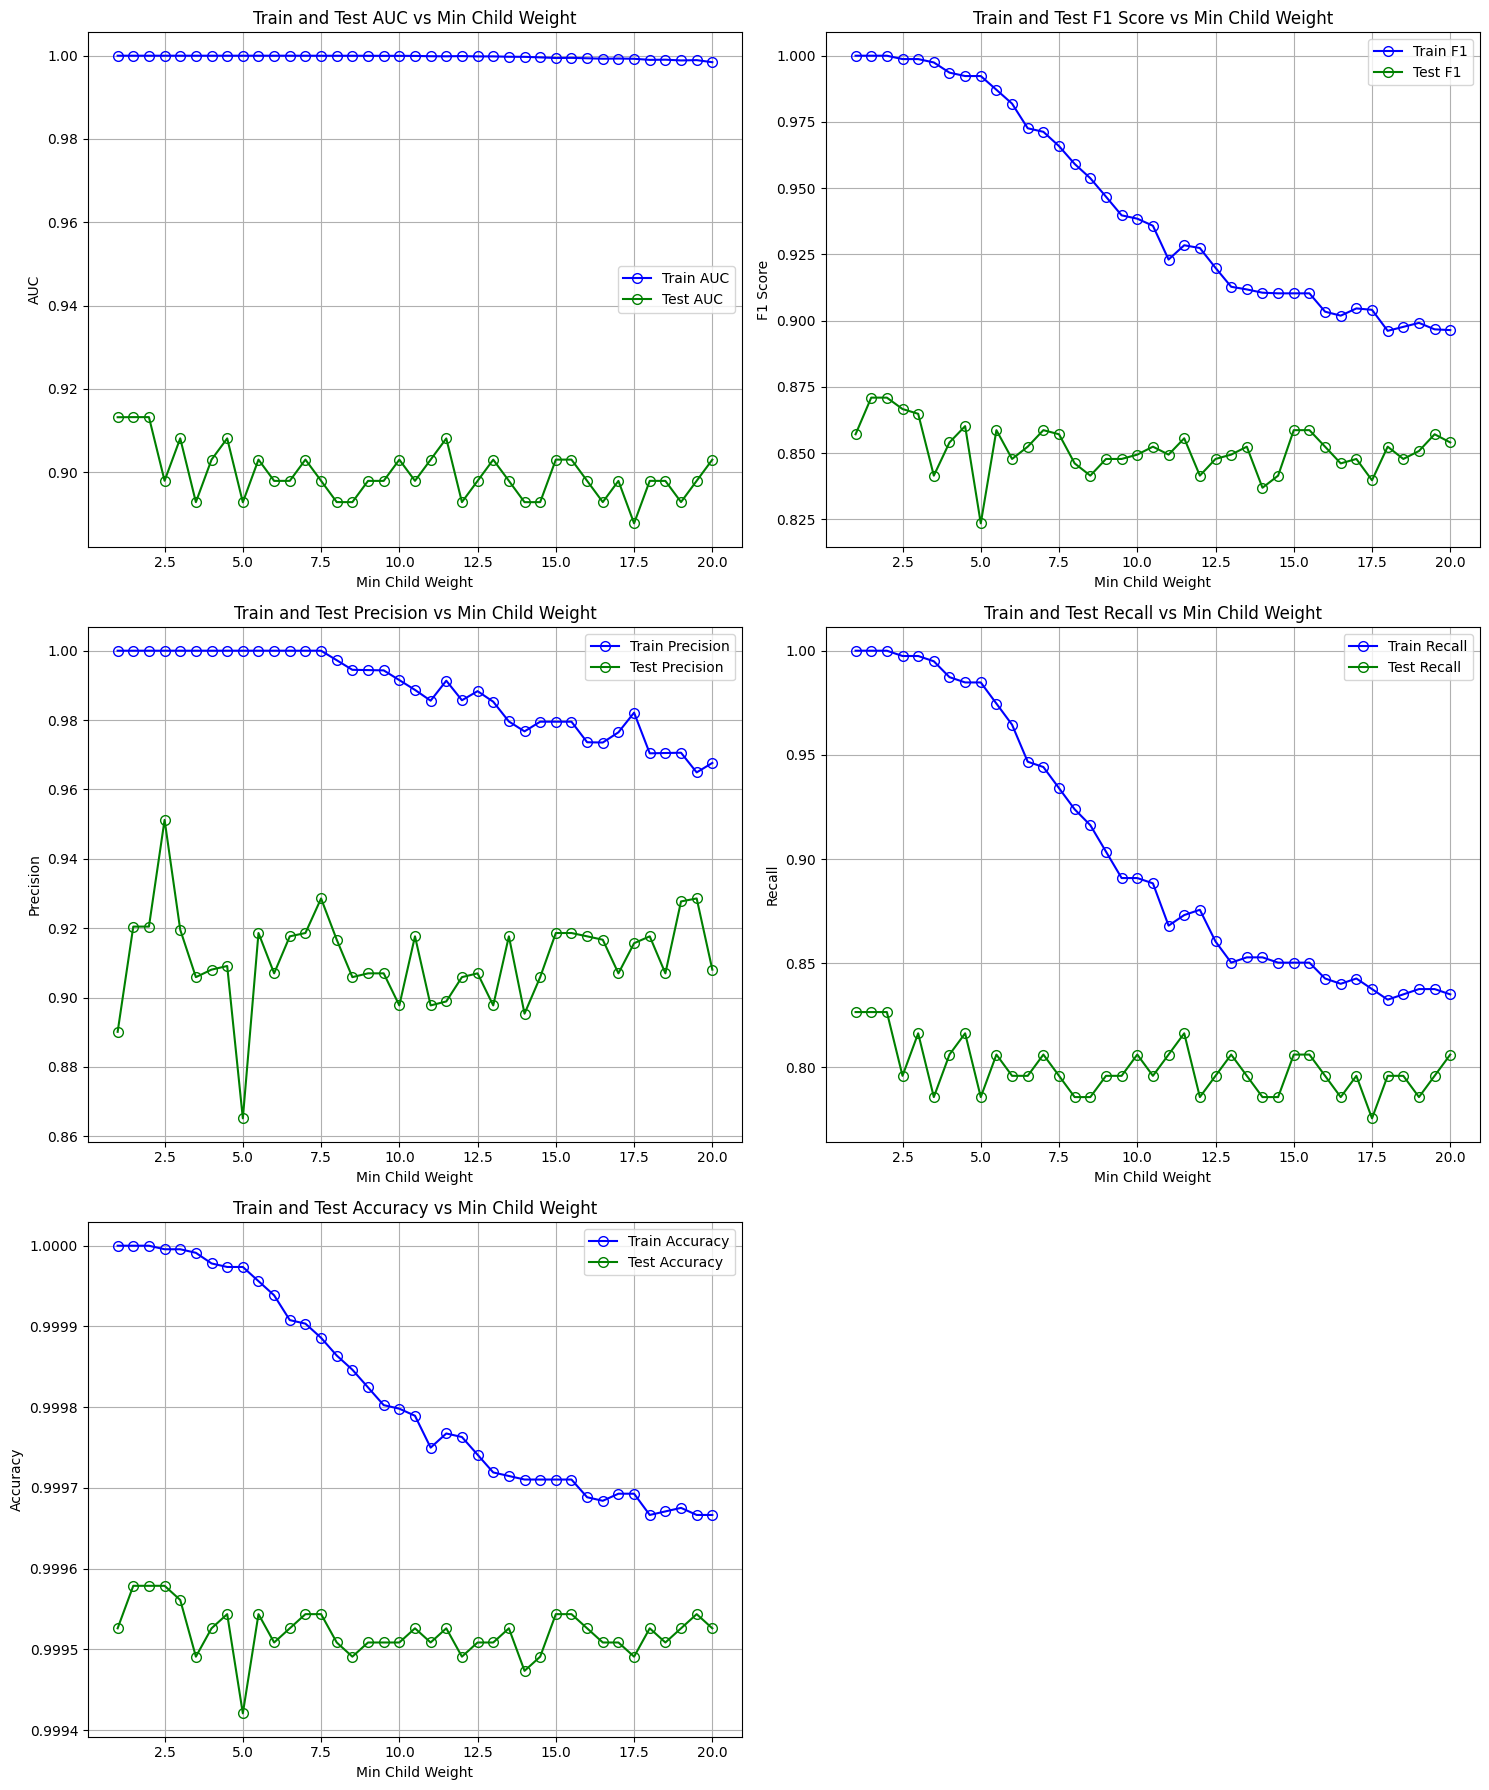


Best Min Child Weight for AUC: 1.5
Best Test AUC: 0.9132

Best Min Child Weight for F1: 1.5
Best Test F1: 0.8710

Best Min Child Weight for Precision: 2.5
Best Test Precision: 0.9512

Best Min Child Weight for Recall: 1.0
Best Test Recall: 0.8265

Best Min Child Weight for Accuracy: 1.5
Best Test Accuracy: 0.9996


In [ ]:
# Create the subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Define colors and marker size
train_color = 'blue'
test_color = 'green'
marker_size = 7  # Adjust this value for finer dots

# Plot 1: Train and Test AUC vs min_child_weight
axes[0, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_AUC'], label='Train AUC',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_AUC'], label='Test AUC',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 0].set_xlabel('Min Child Weight')
axes[0, 0].set_ylabel('AUC')
axes[0, 0].set_title('Train and Test AUC vs Min Child Weight')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Train and Test F1 vs min_child_weight
axes[0, 1].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_F1'], label='Train F1',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[0, 1].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_F1'], label='Test F1',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[0, 1].set_xlabel('Min Child Weight')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Train and Test F1 Score vs Min Child Weight')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Train and Test Precision vs min_child_weight
axes[1, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_Precision'], label='Train Precision',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_Precision'], label='Test Precision',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 0].set_xlabel('Min Child Weight')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Train and Test Precision vs Min Child Weight')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Train and Test Recall vs min_child_weight
axes[1, 1].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_Recall'], label='Train Recall',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[1, 1].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_Recall'], label='Test Recall',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[1, 1].set_xlabel('Min Child Weight')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Train and Test Recall vs Min Child Weight')
axes[1, 1].legend()
axes[1, 1].grid(True)

# Plot 5: Train and Test Accuracy vs min_child_weight
axes[2, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Train_Accuracy'], label='Train Accuracy',
                marker='o', markersize=marker_size, markerfacecolor='none', color=train_color)
axes[2, 0].plot(all_metrics_data['min_child_weight'], all_metrics_data['Test_Accuracy'], label='Test Accuracy',
                marker='o', markersize=marker_size, markerfacecolor='none', color=test_color)
axes[2, 0].set_xlabel('Min Child Weight')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].set_title('Train and Test Accuracy vs Min Child Weight')
axes[2, 0].legend()
axes[2, 0].grid(True)

# Remove the empty subplot
axes[2, 1].remove()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# Print best min_child_weight values for each metric
metrics = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
for metric in metrics:
    best_round_idx = all_metrics_data[f'Test_{metric}'].idxmax()
    best_round = all_metrics_data.loc[best_round_idx, 'min_child_weight']
    best_score = all_metrics_data.loc[best_round_idx, f'Test_{metric}']
    print(f"\nBest Min Child Weight for {metric}: {best_round}")
    print(f"Best Test {metric}: {best_score:.4f}")


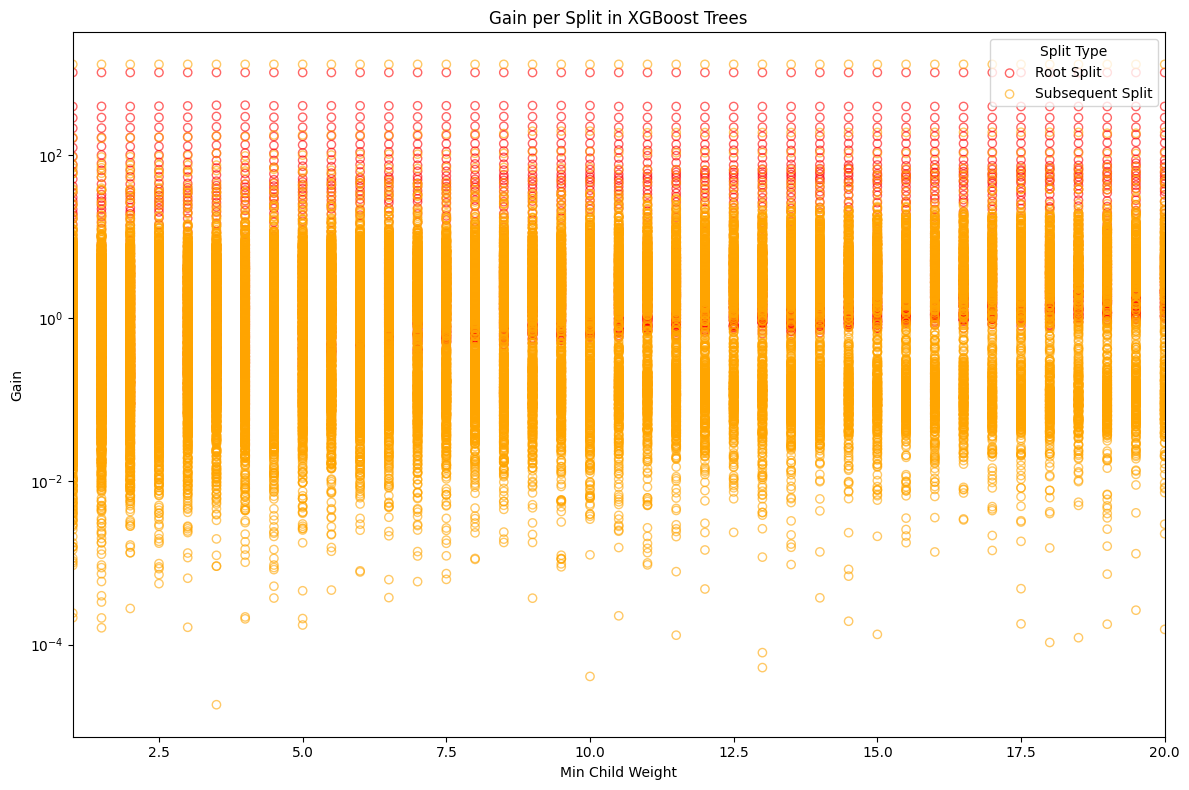

In [ ]:
# Define the feature for the X-axis
feature = 'min_child_weight'

# Create the plot
plt.figure(figsize=(12, 8))

# Plotting for root splits (is_root_split=True)
sns.scatterplot(
    data=all_gain_data[all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    color='red',                   # Red edge color for root splits
    sizes=(20, 500),
    edgecolor='red',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Plotting for non-root splits (is_root_split=False)
sns.scatterplot(
    data=all_gain_data[~all_gain_data['is_root_split']],
    x=feature,
    y='Gain',
    color='orange',                # Orange edge color for subsequent splits
    sizes=(20, 500),
    edgecolor='orange',
    facecolors='none',             # Hollow inside
    linewidth=1,
    alpha=0.6
)

# Set plot labels and title
plt.xlim(all_gain_data[feature].min(), all_gain_data[feature].max())
plt.title('Gain per Split in XGBoost Trees')
plt.xlabel('Min Child Weight')
plt.ylabel('Gain')

# Adjust the legend title and labels manually
plt.legend(['Root Split', 'Subsequent Split'], title='Split Type', loc='upper right')

# Set the Y-axis to a logarithmic scale
plt.yscale('log')

# Remove the grid lines
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()